#           Natural Language Processing: Twitter Sentiment Analysis 

In [ ]:
import pandas as pd
import numpy as np
import csv
import nltk
import string
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import random

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer

import pickle
import re
from collections import Counter
from string import punctuation
import tweepy
from tweepy import OAuthHandler
import json
from wordcloud import WordCloud

import plotly
import plotly.plotly as py
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.go_offline()

pd.set_option('display.max_colwidth', -1)
plt.style.use('seaborn-white')


## Step 1: Explore Training Dataset 

### Positive => 1 and Negative => 0

In [4]:
col = ['ItemID','Sentiment','SentimentText']
data = pd.read_csv('train.csv', header=None, names=col, error_bad_lines=False)
print('length of data : ',len(data))
data.head()

length of data :  99989


,ItemID,Sentiment,SentimentText
0,1,0,is so sad for my APL friend.............
1,2,0,I missed the New Moon trailer...
2,3,1,omg its already 7:30 :O
3,4,0,.. Omgaga. Im sooo im gunna CRy. I've been at...
4,5,0,I think mi bf is cheating on me!!! T_T


In [91]:
# get text and matching label columns
data = data.drop(['ItemID'],axis=1)
data.head()

,Sentiment,SentimentText
0,0,is so sad for my APL friend.............
1,0,I missed the New Moon trailer...
2,1,omg its already 7:30 :O
3,0,.. Omgaga. Im sooo im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)...
4,0,I think mi bf is cheating on me!!! T_T


In [93]:
# check the number of positive vs. negative tagged sentences
positives = data['Sentiment'][data.Sentiment == 0]
negatives = data['Sentiment'][data.Sentiment == 1]

print('number of positve tagged sentences is:  {}'.format(len(positives)))
print('number of negative tagged sentences is: {}'.format(len(negatives)))
print('total length of the data is:            {}'.format(data.shape[0]))

number of positve tagged sentences is:  43532
number of negative tagged sentences is: 56457
total length of the data is:            99989


In [94]:
# get unique label counts
data.groupby('Sentiment').describe()

SentimentText                   
                  count unique    top freq
Sentiment                                 
0          43484         42744  &quot  474
1          56424         55266  &quot  885

In [99]:
data['SentimentText']

0        is so sad for my APL friend.............                                                                                                  
1        I missed the New Moon trailer...                                                                                                          
2        omg its already 7:30 :O                                                                                                                   
3        .. Omgaga. Im sooo  im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)...                
4        I think mi bf is cheating on me!!!       T_T                                                                                              
5        or i just worry too much?                                                                                                                 
6        Juuuuuuuuuuuuuuuuussssst Chillin!!                                                                     

In [114]:
# get a word count per sentence column
def word_count(sentence):
    return len(str(sentence).split())

data['word count'] = data['SentimentText'].apply(word_count)
data.head()

,Sentiment,SentimentText,word count
0,0,is so sad for my APL friend.............,7
1,0,I missed the New Moon trailer...,6
2,1,omg its already 7:30 :O,5
3,0,.. Omgaga. Im sooo im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)...,25
4,0,I think mi bf is cheating on me!!! T_T,9


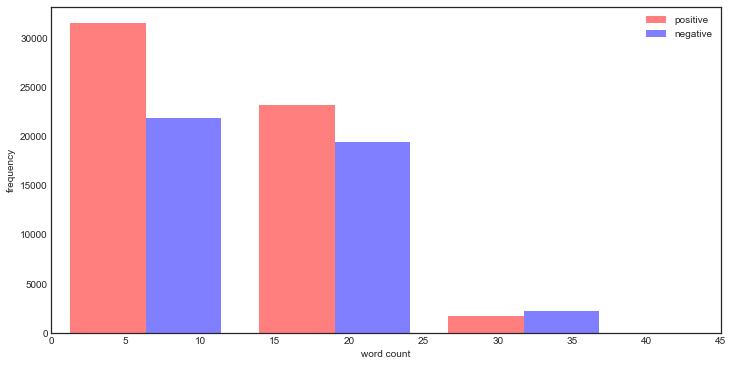

In [116]:
# plot word count distribution for both positive and negative sentiments
x = data['word count'][data.Sentiment == 1]
y = data['word count'][data.Sentiment == 0]
plt.figure(figsize=(12,6))
plt.xlim(0,45)
plt.xlabel('word count')
plt.ylabel('frequency')
g = plt.hist([x, y], color=['r','b'], alpha=0.5, label=['positive','negative'])
plt.legend(loc='upper right')

In [119]:
# get most common words in training dataset
all_words = []
for line in list(data['SentimentText']):
    words = str(line).split()
    for word in words:
        all_words.append(word.lower())
    
    
Counter(all_words).most_common(10)

[('i', 47369),
 ('the', 28202),
 ('to', 27918),
 ('you', 22674),
 ('a', 20825),
 ('and', 15189),
 ('it', 13612),
 ('my', 12853),
 ('for', 11856),
 ('is', 10911)]

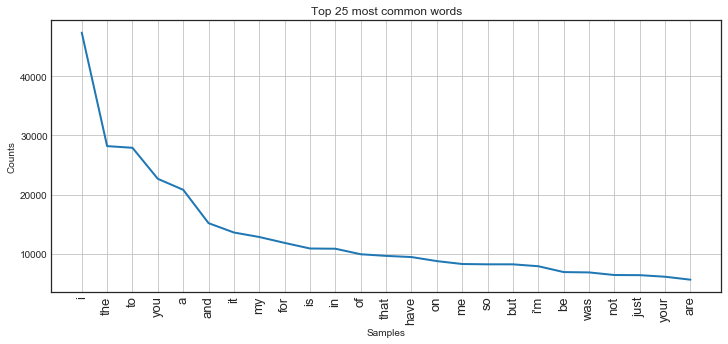

Text(0.5, 1.0, 'log-log plot of words frequency')

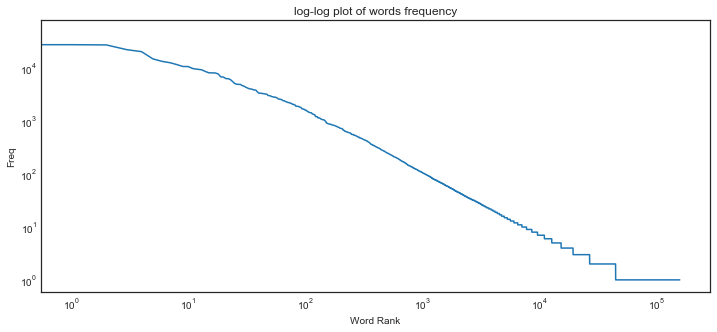

In [120]:
# plot word frequency distribution of first few words
plt.figure(figsize=(12,5))
plt.title('Top 25 most common words')
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_words)
fd.plot(25,cumulative=False)

# log-log plot
word_counts = sorted(Counter(all_words).values(), reverse=True)
plt.figure(figsize=(12,5))
plt.loglog(word_counts, linestyle='-', linewidth=1.5)
plt.ylabel("Freq")
plt.xlabel("Word Rank")
plt.title('log-log plot of words frequency')

## Step 2: Crawl Tweets Against Hash Tags

### Download Twitter data through API

### credentials here

In [9]:
consumer_key = ''
consumer_secret = ''
access_token = ''
access_token_secret = ''

In [10]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)

### Topic: ModiwinsRafale

In [39]:
# Open/Create a file to append data
csvFile = open('test.csv', 'a', encoding='utf-8')
#Use csv Writer
csvWriter = csv.writer(csvFile)

In [40]:
# get data from twitter
tweet_num = 0
for tweet in tweepy.Cursor(api.search,q="#ModiWinsOnRafale",count=10,lang="en",since="2018-12-14").items():
        if tweet.place is not None:
            try:
                # not entirely necessary but you can inspect what is being written to file
                print ('tweet number: {}'.format(tweet_num), tweet.text, tweet.place.full_name)
                # write data to csv
                csvWriter.writerow([tweet.created_at,
                                    tweet.user.location,
                                    tweet.user.followers_count,
                                    tweet.user.friends_count,
                                    tweet.text,
                                    tweet.place.bounding_box.coordinates,
                                    tweet.place.full_name,
                                    tweet.place.country,
                                    tweet.place.country_code,
                                    tweet.place.place_type])
                
                tweet_num = tweet_num + 1
            except Exception:
                pass

tweet number: 0 Why we Indians tolerating this guy called @RahulGandhi who is on bail? Acc to him, he and his corrupt family are al… https://t.co/Kx4dlh59wy New Delhi, India
tweet number: 1 Rahul Gandhi Don't  Trust Own Mother Because Rahul Gandhi's DNA Never Match  with Rajiv Gandhi, So how he Going To… https://t.co/o3BBMjlQau Alipur, India
tweet number: 2 Looks like Rahul is leader of Liars brigade. Indians are being taken for a ride. #ModiWinsOnRafale Indore, India
tweet number: 3 Truth Always WINs.
It feels so sad while the hard working  Pradhan Sevak of the Nation is blammed without reasons.
#ModiWinsOnRafale New Delhi, India
tweet number: 4 It's great to see India having so many defance expert..🤔 #RafaleDeal #ModiRafaleWin #ModiWinsOnRafale #RafaleVerdict New Delhi, India
tweet number: 5 #Rafale
R_ahul
A_gain
F_ailed
A_ll
L_ies
E_xposed
#ModiWinsOnRafale #SCNailsRaGaLies #RafaleVerdict #KamalNath… https://t.co/8xkgeoJ01a Alipur, India
tweet number: 6 When it suits them SC is Good

KeyboardInterrupt: 


## Step 3: Build a working dataframe and visualize data and do some data cleaning

In [143]:
# create column names
col_names=['date','user_loc','followers','friends','message','bbox_coords',\
           'full_name','country','country_code','place_type']

# read csv
df_twtr = pd.read_csv('demo1.csv', names=col_names)

# check head
df_twtr.head()

,date,user_loc,followers,friends,message,bbox_coords,full_name,country,country_code,place_type
0,2018-12-14 19:18:33,"New Delhi, India",684,312,"Why we Indians tolerating this guy called @RahulGandhi who is on bail? Acc to him, he and his corrupt family are al… https://t.co/Kx4dlh59wy","[[[76.84252, 28.397657], [77.347652, 28.397657], [77.347652, 28.879322], [76.84252, 28.879322]]]","New Delhi, India",India,IN,city
1,2018-12-14 19:08:59,"कोलकाता, भारत",15,222,"Rahul Gandhi Don't Trust Own Mother Because Rahul Gandhi's DNA Never Match with Rajiv Gandhi, So how he Going To… https://t.co/o3BBMjlQau","[[[88.409391, 21.817199], [88.824146, 21.817199], [88.824146, 22.587415], [88.409391, 22.587415]]]","Alipur, India",India,IN,city
2,2018-12-14 18:51:58,NaN,3,4,Looks like Rahul is leader of Liars brigade. Indians are being taken for a ride. #ModiWinsOnRafale,"[[[75.690789, 22.525584], [76.245579, 22.525584], [76.245579, 22.817381], [75.690789, 22.817381]]]","Indore, India",India,IN,city
3,2018-12-14 18:48:52,"New Delhi, India",1223,3670,Truth Always WINs.\nIt feels so sad while the hard working Pradhan Sevak of the Nation is blammed without reasons.\n#ModiWinsOnRafale,"[[[76.84252, 28.397657], [77.347652, 28.397657], [77.347652, 28.879322], [76.84252, 28.879322]]]","New Delhi, India",India,IN,city
4,2018-12-14 18:48:11,Bhopal _ Delhi,326,1107,It's great to see India having so many defance expert..🤔 #RafaleDeal #ModiRafaleWin #ModiWinsOnRafale #RafaleVerdict,"[[[76.84252, 28.397657], [77.347652, 28.397657], [77.347652, 28.879322], [76.84252, 28.879322]]]","New Delhi, India",India,IN,city


In [144]:
# Sort dataframe by date column
df_twtr['date'] = pd.to_datetime(df_twtr['date'])
df_twtr = df_twtr.sort_values(by='date',ascending=True)
df_twtr = df_twtr.reset_index().drop('index',axis=1)
df_twtr.head()

,date,user_loc,followers,friends,message,bbox_coords,full_name,country,country_code,place_type
0,2018-12-14 17:10:16,"Bhubaneshwar, India",73,107,It seems all except those out on the bail lied #ModiWinsOnRafale,"[[[77.3305776, 12.731936], [77.7863188, 12.731936], [77.7863188, 13.1142933], [77.3305776, 13.1142933]]]","Bengaluru South, India",India,IN,city
1,2018-12-14 17:11:39,Chennai,10575,2773,@Iyervval ji. You are speaking in a very soft tone. Pls raise your voice and speak. #ModiWinsOnRafale,"[[[80.183081, 12.965942], [80.252142, 12.965942], [80.252142, 13.060495], [80.183081, 13.060495]]]","Chennai, India",India,IN,city
2,2018-12-14 17:14:06,Mumbai,207,245,@republic should invite some intelligent spokesperson from opposition parties... at least not @JohnDayal .... #ModiWinsOnRafale,"[[[72.74484, 18.845343], [73.003648, 18.845343], [73.003648, 19.502937], [72.74484, 19.502937]]]","Mumbai, India",India,IN,city
3,2018-12-14 17:16:43,"NEW DELHI, INDIA",1358,1759,"#ModiWinsOnRafale When the stupid lobby does not have any answers they jump on Muslim, Dalit issues","[[[76.84252, 28.397657], [77.347652, 28.397657], [77.347652, 28.879322], [76.84252, 28.879322]]]","New Delhi, India",India,IN,city
4,2018-12-14 17:17:40,"ÜT: 19.165487,72.853263",1088,1422,"No matter what, just blame modi #ModiWinsOnRafale","[[[72.74484, 18.845343], [73.003648, 18.845343], [73.003648, 19.502937], [72.74484, 19.502937]]]","Mumbai, India",India,IN,city


In [145]:
# get central geo location from the bounding box for later mapping

# helper function to get mean of lats and longs
def geo_mean(x):
    y = json.loads(x)
    y = np.asarray(y)
    mean_geoloc = np.add(np.add((y[:][0][0]),(y[:][0][1]))/2,\
                         (np.add((y[:][0][2]),(y[:][0][3]))/2))/2    
    return np.around(mean_geoloc,decimals=6)

# ____________________________________________________________

# append new column  and clean up df
df_twtr['geo_code'] = df_twtr['bbox_coords'].apply(geo_mean)
df_twtr = df_twtr.drop(['bbox_coords','place_type','followers','friends'],axis=1)
df_twtr.head()

,date,user_loc,message,full_name,country,country_code,geo_code
0,2018-12-14 17:10:16,"Bhubaneshwar, India",It seems all except those out on the bail lied #ModiWinsOnRafale,"Bengaluru South, India",India,IN,"[77.558448, 12.923115]"
1,2018-12-14 17:11:39,Chennai,@Iyervval ji. You are speaking in a very soft tone. Pls raise your voice and speak. #ModiWinsOnRafale,"Chennai, India",India,IN,"[80.217612, 13.013218]"
2,2018-12-14 17:14:06,Mumbai,@republic should invite some intelligent spokesperson from opposition parties... at least not @JohnDayal .... #ModiWinsOnRafale,"Mumbai, India",India,IN,"[72.874244, 19.17414]"
3,2018-12-14 17:16:43,"NEW DELHI, INDIA","#ModiWinsOnRafale When the stupid lobby does not have any answers they jump on Muslim, Dalit issues","New Delhi, India",India,IN,"[77.095086, 28.63849]"
4,2018-12-14 17:17:40,"ÜT: 19.165487,72.853263","No matter what, just blame modi #ModiWinsOnRafale","Mumbai, India",India,IN,"[72.874244, 19.17414]"


In [146]:
df_twtr.to_pickle('df_rafale.p') # save dframe to pickle

In [147]:
df_rafale = pd.read_pickle('df_rafale.p')  # load from pickle


## Step 4: Text Pre-processing

### Pre-processing 1: Clean tweet text by removing links, special characters

In [148]:
# helper function to clean tweets
def processTweet(tweet):
    # Remove HTML special entities (e.g. &amp;)
    tweet = re.sub(r'\&\w*;', '', tweet)
    #Convert @username to AT_USER
    tweet = re.sub('@[^\s]+','',tweet)
    # Remove tickers
    tweet = re.sub(r'\$\w*', '', tweet)
    # To lowercase
    tweet = tweet.lower()
    # Remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    # Remove hashtags
    tweet = re.sub(r'#\w*', '', tweet)
    # Remove Punctuation and split 's, 't, 've with a space for filter
    tweet = re.sub(r'[' + punctuation.replace('@', '') + ']+', ' ', tweet)
    # Remove words with 2 or fewer letters
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
    # Remove whitespace (including new line characters)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    # Remove single space remaining at the front of the tweet.
    tweet = tweet.lstrip(' ') 
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    tweet = ''.join(c for c in tweet if c <= '\uFFFF') 
    return tweet
# ______________________________________________________________

# clean dataframe's text column
df_rafale['message'] = df_rafale['message'].apply(processTweet)
# preview some cleaned tweets
df_rafale['message'].head()

0    seems all except those out the bail lied                                      
1    you are speaking very soft tone pls raise your voice and speak                
2    should invite some intelligent spokesperson from opposition parties least not 
3    when the stupid lobby does not have any answers they jump muslim dalit issues 
4    matter what just blame modi                                                   
Name: message, dtype: object

In [149]:
#hit and trial
before = df_rafale['message'][2]
after = processTweet(before)

before,'\n',after

('should invite some intelligent spokesperson from opposition parties least not ',
 '\n',
 'should invite some intelligent spokesperson from opposition parties least not ')

#### most common words in twitter dataset

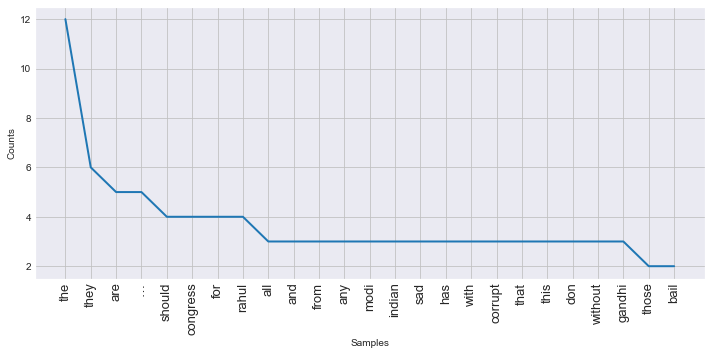

Text(0.5, 0, 'Word Rank')

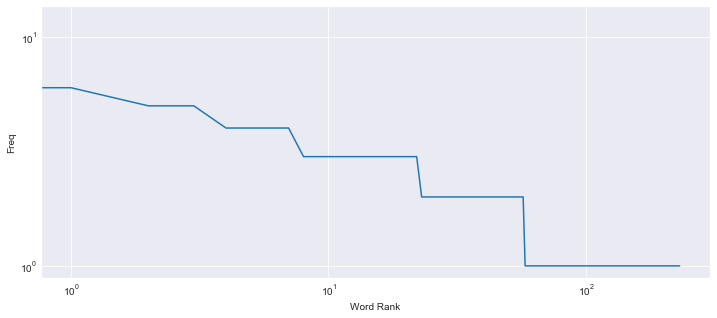

In [150]:
# most common words in twitter dataset
all_words = []
for line in list(df_rafale['message']):
    words = line.split()
    for word in words:
        all_words.append(word.lower())

# plot word frequency distribution of first few words
plt.figure(figsize=(12,5))
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_words)
fd.plot(25,cumulative=False)

# log-log of all words 
word_counts = sorted(Counter(all_words).values(), reverse=True)

plt.figure(figsize=(12,5))
plt.loglog(word_counts, linestyle='-', linewidth=1.5)
plt.ylabel("Freq")
plt.xlabel("Word Rank")

#### Drop duplicate tweets as they bring no new information to the dataset and are also computationally inefficient.


In [151]:
# drop duplicates
df_rafale = df_rafale.drop_duplicates('message')
df_rafale.shape

(27, 7)

### Pre-processing 2: Tokenize without out Stop-Words 

In [152]:
# show stop words examples
stop_words = stopwords.words('english') # Show some stop words
' , '.join(stop_words)[:200], len(stop_words)

("i , me , my , myself , we , our , ours , ourselves , you , you're , you've , you'll , you'd , your , yours , yourself , yourselves , he , him , his , himself , she , she's , her , hers , herself , it ",
 179)

In [153]:
# tokenize helper function
def text_process(raw_text):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in list(raw_text) if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.lower().split() if word.lower() not in stopwords.words('english')]


def remove_words(word_list):
    remove = ['modi','rahul','...','“','”','’','…','rahul’']
    return [w for w in word_list if w not in remove]

# -------------------------------------------

# tokenize message column and create a column for tokens
df_rafale = df_rafale.copy()
df_rafale['tokens'] = df_rafale['message'].apply(text_process) # tokenize style 1
df_rafale['no_rafale'] = df_rafale['tokens'].apply(remove_words) #tokenize style 2
df_rafale.head()

,date,user_loc,message,full_name,country,country_code,geo_code,tokens,no_rafale
0,2018-12-14 17:10:16,"Bhubaneshwar, India",seems all except those out the bail lied,"Bengaluru South, India",India,IN,"[77.558448, 12.923115]","[seems, except, bail, lied]","[seems, except, bail, lied]"
1,2018-12-14 17:11:39,Chennai,you are speaking very soft tone pls raise your voice and speak,"Chennai, India",India,IN,"[80.217612, 13.013218]","[speaking, soft, tone, pls, raise, voice, speak]","[speaking, soft, tone, pls, raise, voice, speak]"
2,2018-12-14 17:14:06,Mumbai,should invite some intelligent spokesperson from opposition parties least not,"Mumbai, India",India,IN,"[72.874244, 19.17414]","[invite, intelligent, spokesperson, opposition, parties, least]","[invite, intelligent, spokesperson, opposition, parties, least]"
3,2018-12-14 17:16:43,"NEW DELHI, INDIA",when the stupid lobby does not have any answers they jump muslim dalit issues,"New Delhi, India",India,IN,"[77.095086, 28.63849]","[stupid, lobby, answers, jump, muslim, dalit, issues]","[stupid, lobby, answers, jump, muslim, dalit, issues]"
4,2018-12-14 17:17:40,"ÜT: 19.165487,72.853263",matter what just blame modi,"Mumbai, India",India,IN,"[72.874244, 19.17414]","[matter, blame, modi]","[matter, blame]"


In [154]:
# style 1 tokens
df_rafale['tokens'].head(10)

0    [seems, except, bail, lied]                                              
1    [speaking, soft, tone, pls, raise, voice, speak]                         
2    [invite, intelligent, spokesperson, opposition, parties, least]          
3    [stupid, lobby, answers, jump, muslim, dalit, issues]                    
4    [matter, blame, modi]                                                    
5    [congress, big, lier, disgress, indian, people, becomes, full, time, sad]
6    [proved, mithyamev, jayate, states, gone, mad, result, stop, …]          
7    [whose, grandmother, money, kept, dhirubhai, ambani]                     
8    [pathological, liar, stop, peddling, lies, forthwith]                    
9    [still, questioning, rafael, intellectual, terrorist, people, handle]    
Name: tokens, dtype: object

In [155]:
# style 2 tokens
df_rafale['no_rafale'].head(10)

0    [seems, except, bail, lied]                                              
1    [speaking, soft, tone, pls, raise, voice, speak]                         
2    [invite, intelligent, spokesperson, opposition, parties, least]          
3    [stupid, lobby, answers, jump, muslim, dalit, issues]                    
4    [matter, blame]                                                          
5    [congress, big, lier, disgress, indian, people, becomes, full, time, sad]
6    [proved, mithyamev, jayate, states, gone, mad, result, stop]             
7    [whose, grandmother, money, kept, dhirubhai, ambani]                     
8    [pathological, liar, stop, peddling, lies, forthwith]                    
9    [still, questioning, rafael, intellectual, terrorist, people, handle]    
Name: no_rafale, dtype: object

#### most common words in twitter dataset after Tokenizing

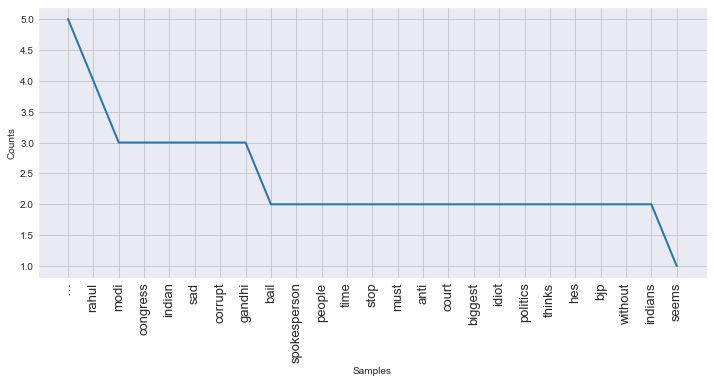

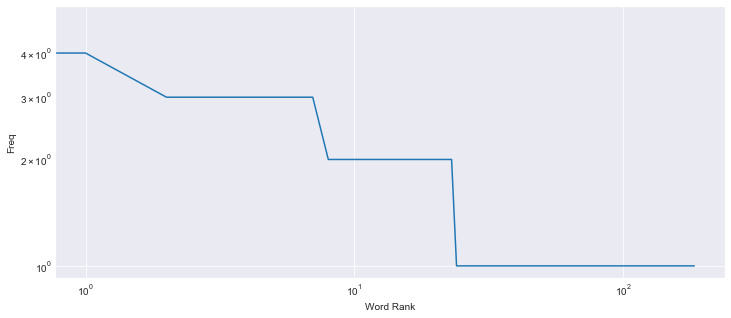

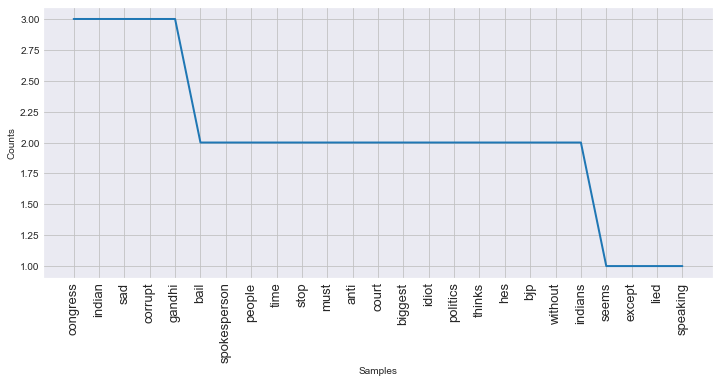

Text(0.5, 0, 'Word Rank')

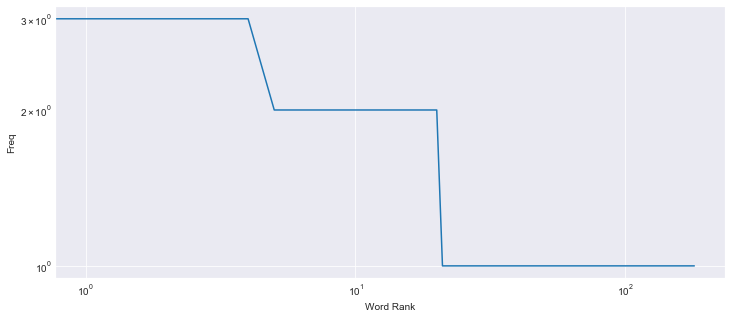

In [156]:
# most common words in twitter dataset
all_words = []
for ls in df_rafale['tokens']:
    words = [w for w in ls]
    for word in words:
        all_words.append(word.lower())
    
# plot word frequency distribution of first few words
plt.figure(figsize=(12,5))
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_words)
fd.plot(25,cumulative=False)

# log-log  of all words 
word_counts = sorted(Counter(all_words).values(), reverse=True)
plt.figure(figsize=(12,5))
plt.loglog(word_counts, linestyle='-', linewidth=1.5)
plt.ylabel("Freq")
plt.xlabel("Word Rank")

# plot word frequency distribution of first few words without paul, ryan
# no_rafale
no_rafale = []
for ls in df_rafale['no_rafale']:
    words = [w for w in ls]
    for word in words:
        no_rafale.append(word)
plt.figure(figsize=(12,5))
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(no_rafale)
fd.plot(25,cumulative=False)

# log-log  of all words -- no_rafale 
word_counts = sorted(Counter(no_rafale).values(), reverse=True)
plt.figure(figsize=(12,5))
plt.loglog(word_counts, linestyle='-', linewidth=1.5)
plt.ylabel("Freq")
plt.xlabel("Word Rank")

#### generating individual words from sentences

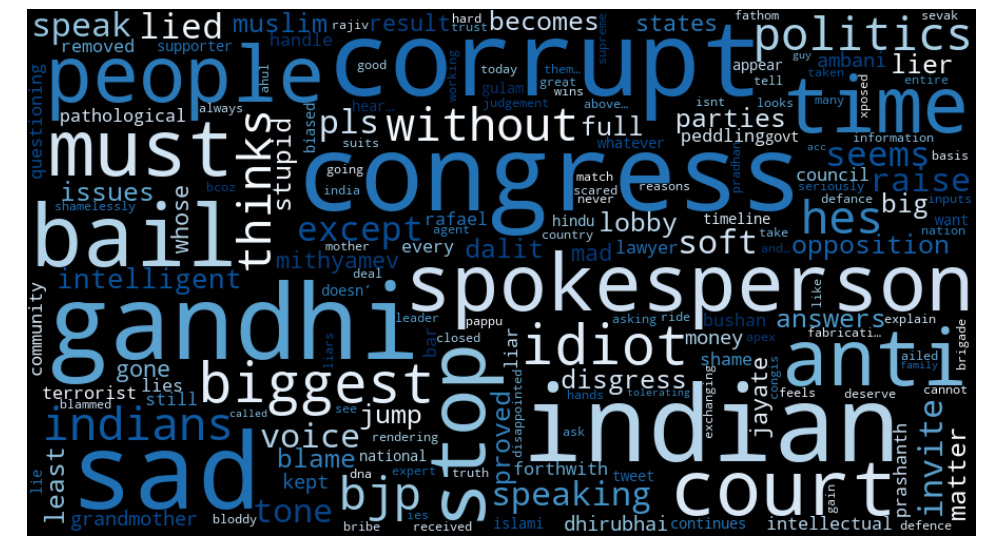

In [157]:
# split sentences to get individual words
all_words = []
for line in df_rafale['no_rafale']: # try 'tokens'
    all_words.extend(line)
    
# create a word frequency dictionary
wordfreq = Counter(all_words)

# draw a Word Cloud with word frequencies
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Blues',
                      normalize_plurals=True).generate_from_frequencies(wordfreq)

plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Pre-processing 3: Feature Extraction

#### Vectorization - (Bag Of Words)

In [158]:
# vetorize
bow_transformer = CountVectorizer(analyzer=text_process).fit(df_rafale['message'])
# print total number of vocab words
print(len(bow_transformer.vocabulary_))

185


In [159]:
# uncomment to view the entire word vocabulary 
#bow_transformer.vocabulary_

In [160]:
# example of vectorized text
sample_tweet = df_rafale['message'][5]
print(sample_tweet)
print('\n')
# vector representation
bow_sample = bow_transformer.transform([sample_tweet])
print(bow_sample)
print('\n')

congress big lier its disgress indian people who becomes full all time very sad 


  (0, 18)	1
  (0, 20)	1
  (0, 34)	1
  (0, 47)	1
  (0, 61)	1
  (0, 81)	1
  (0, 102)	1
  (0, 125)	1
  (0, 142)	1
  (0, 167)	1




In [161]:
# transform the entire DataFrame of messages
messages_bow = bow_transformer.transform(df_rafale['message'])

# check out the bag-of-words counts for the entire corpus as a large sparse matrix
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

Shape of Sparse Matrix:  (27, 185)
Amount of Non-Zero occurences:  216


#### Term Frequency, Inverse Document Frequency

In [162]:
# from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf_sample = tfidf_transformer.transform(bow_sample)
print(tfidf_sample)

  (0, 167)	0.3039741785882917
  (0, 142)	0.27693059495814853
  (0, 125)	0.3039741785882917
  (0, 102)	0.3420899689355198
  (0, 81)	0.27693059495814853
  (0, 61)	0.3420899689355198
  (0, 47)	0.3420899689355198
  (0, 34)	0.27693059495814853
  (0, 20)	0.3420899689355198
  (0, 18)	0.3420899689355198


In [163]:
# some IDF (inverse document frequency) example
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['congress']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['lie']])

2.9459101490553135
3.6390573296152584


In [164]:
# to transform the entire bag-of-words corpus
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(27, 185)



## Step 5: First Model Training and Evaluation

### Naive Bayes Classifier

#### Create Pipeline to manage the above preprocessing steps in one step 

In [165]:
# Run Train Data Through Pipeline analyzer=text_process
# uncomment below to train on a larger dataset but it is very slow for a regular laptop

# X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(data['SentimentText'][:5000], data['Sentiment'][:5000], test_size=0.2)


# create pipeline
pipeline = Pipeline([
    ('bow', CountVectorizer(strip_accents='ascii',
                            stop_words='english',
                            lowercase=True)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

# this is where we define the values for GridSearchCV to iterate over
parameters = {'bow__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'classifier__alpha': (1e-2, 1e-3),
             }

# do 10-fold cross validation for each of the 6 possible combinations of the above params
grid = GridSearchCV(pipeline, cv=10, param_grid=parameters, verbose=1)
grid.fit(X_train,y_train)

# summarize results
print("\nBest Model: %f using %s" % (grid.best_score_, grid.best_params_))
print('\n')
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Mean: %f Stdev:(%f) with: %r" % (mean, stdev, param))

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  1.7min finished



Best Model: 0.751750 using {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.01, 'tfidf__use_idf': False}


Mean: 0.741250 Stdev:(0.011815) with: {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.01, 'tfidf__use_idf': True}
Mean: 0.751750 Stdev:(0.011386) with: {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.01, 'tfidf__use_idf': False}
Mean: 0.738500 Stdev:(0.012244) with: {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.001, 'tfidf__use_idf': True}
Mean: 0.744500 Stdev:(0.010589) with: {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.001, 'tfidf__use_idf': False}
Mean: 0.742250 Stdev:(0.015903) with: {'bow__ngram_range': (1, 2), 'classifier__alpha': 0.01, 'tfidf__use_idf': True}
Mean: 0.749500 Stdev:(0.016975) with: {'bow__ngram_range': (1, 2), 'classifier__alpha': 0.01, 'tfidf__use_idf': False}
Mean: 0.737750 Stdev:(0.015091) with: {'bow__ngram_range': (1, 2), 'classifier__alpha': 0.001, 'tfidf__use_idf': True}
Mean: 0.745000 Stdev:(0.018417) with: {'bow__ngram_range'

In [166]:
# save best model to current working directory
joblib.dump(grid, "twitter_sentiment.pkl")

['twitter_sentiment.pkl']

In [167]:
# load from file and predict using the best configs found in the CV step
model_NB = joblib.load("twitter_sentiment.pkl" )

# get predictions from best model above
y_preds = model_NB.predict(X_test)

print('accuracy score: ',accuracy_score(y_test, y_preds))
print('\n')
print('confusion matrix: \n',confusion_matrix(y_test,y_preds))
print('\n')
print(classification_report(y_test, y_preds))

accuracy score:  0.755


confusion matrix: 
 [[644  59]
 [186 111]]


              precision    recall  f1-score   support

           0       0.78      0.92      0.84       703
           1       0.65      0.37      0.48       297

   micro avg       0.76      0.76      0.76      1000
   macro avg       0.71      0.64      0.66      1000
weighted avg       0.74      0.76      0.73      1000




#### Run Prediction On Twitter Data and preview results

In [168]:
# run predictions on twitter data
tweet_preds = model_NB.predict(df_twtr['message'])

# append predictions to dataframe
df_tweet_preds = df_twtr.copy()
df_tweet_preds['predictions'] = tweet_preds
df_tweet_preds.shape

(28, 8)

#### view some example preditions

In [169]:
# print text and sentiment

index = random.sample(range(tweet_preds.shape[0]), 20)
for text, sentiment in zip(df_tweet_preds.message[index],df_tweet_preds.predictions[index]):
    if sentiment== 0:
            score = 'Positive'
    else:
            score = 'Negative'
    print (score, '--', text, '\n')

Positive -- It seems all except those out on the bail lied  #ModiWinsOnRafale 

Positive -- When it suits them SC is Good, now BJP should ask Congress to tell this country from where they received the inputs.#ModiWinsOnRafale 

Positive -- #ModiWinsOnRafale why are u a pathological liar. @RahulGandhi . Stop peddling lies forthwith 

Positive -- #Rafale
R_ahul
A_gain
F_ailed
A_ll
L_ies
E_xposed
#ModiWinsOnRafale #SCNailsRaGaLies #RafaleVerdict #KamalNath… https://t.co/8xkgeoJ01a 

Positive -- Now BJP should go to SC asking Rahul to explain basis of his information.#ModiWinsOnRafale 

Positive -- Rahul Gandhi Don't  Trust Own Mother Because Rahul Gandhi's DNA Never Match  with Rajiv Gandhi, So how he Going To… https://t.co/o3BBMjlQau 

Positive -- It's great to see India having so many defance expert..🤔 #RafaleDeal #ModiRafaleWin #ModiWinsOnRafale #RafaleVerdict 

Positive -- No matter what, just blame modi  #ModiWinsOnRafale 

Positive -- Truth Always WINs.
It feels so sad while the har

In [170]:
pos = df_tweet_preds.predictions.value_counts()[0]
neg = df_tweet_preds.predictions.value_counts()[1]

print('Model predictions: Positives - {}, Negatives - {}'.format(neg,pos))

Model predictions: Positives - 2, Negatives - 26


In [171]:
# Testing random text from the internet

# load model
model_NB = joblib.load("twitter_sentiment.pkl" )

# test string
sample_str = """The whole family of Rahul is Chor : 
Father was Bofors Chor 
Mother is National Herald Chor 
Jija is Land Chor And 
he is making allegation against the person whose Rafale Deal 
has been cleared by Supreme Court #RafaleDealVerdict"""


p = model_NB.predict([sample_str])

# formatting helper
def sentiment_str(x):
    if x==0:
        return 'Negative'
    else:
        return 'Positive'
#_____________________________________________

# test result ___ 0=Negative, 1=Positive
print("the sentence: \n\n'{}' \n\nhas a {} sentiment".format(sample_str,sentiment_str(p[0])))

the sentence: 

'The whole family of Rahul is Chor : 
Father was Bofors Chor 
Mother is National Herald Chor 
Jija is Land Chor And 
he is making allegation against the person whose Rafale Deal 
has been cleared by Supreme Court #RafaleDealVerdict' 

has a Negative sentiment


In [172]:
# save dataframe with appended preditions 
df_tweet_preds.to_pickle('rafale_predicts_df.p')

## Step 6: Geoplots, Final Thoughts and Conclusions

In [173]:
# load dataframe with predictions
df = pd.read_pickle('rafale_predicts_df.p')
df.head()

,date,user_loc,message,full_name,country,country_code,geo_code,predictions
0,2018-12-14 17:10:16,"Bhubaneshwar, India",It seems all except those out on the bail lied #ModiWinsOnRafale,"Bengaluru South, India",India,IN,"[77.558448, 12.923115]",0
1,2018-12-14 17:11:39,Chennai,@Iyervval ji. You are speaking in a very soft tone. Pls raise your voice and speak. #ModiWinsOnRafale,"Chennai, India",India,IN,"[80.217612, 13.013218]",1
2,2018-12-14 17:14:06,Mumbai,@republic should invite some intelligent spokesperson from opposition parties... at least not @JohnDayal .... #ModiWinsOnRafale,"Mumbai, India",India,IN,"[72.874244, 19.17414]",0
3,2018-12-14 17:16:43,"NEW DELHI, INDIA","#ModiWinsOnRafale When the stupid lobby does not have any answers they jump on Muslim, Dalit issues","New Delhi, India",India,IN,"[77.095086, 28.63849]",0
4,2018-12-14 17:17:40,"ÜT: 19.165487,72.853263","No matter what, just blame modi #ModiWinsOnRafale","Mumbai, India",India,IN,"[72.874244, 19.17414]",0


In [174]:
# get all the places in dataset
df.full_name.unique()

array(['Bengaluru South, India', 'Chennai, India', 'Mumbai, India',
       'New Delhi, India', 'Kolkata, India', 'India',
       'Mylapore Tiruvallike, India', 'Guwahati, India', 'Rajkot, India',
       'Indore, India', 'Alipur, India'], dtype=object)

In [175]:
# get top places in the dataset by percentage of tweets
df.full_name.value_counts(1).head(10)

New Delhi, India               0.214286
Alipur, India                  0.142857
Rajkot, India                  0.107143
Indore, India                  0.107143
Mumbai, India                  0.107143
Chennai, India                 0.071429
Guwahati, India                0.071429
Mylapore Tiruvallike, India    0.071429
Kolkata, India                 0.035714
India                          0.035714
Name: full_name, dtype: float64

Text(0, 0.5, '% of Total Tweets')

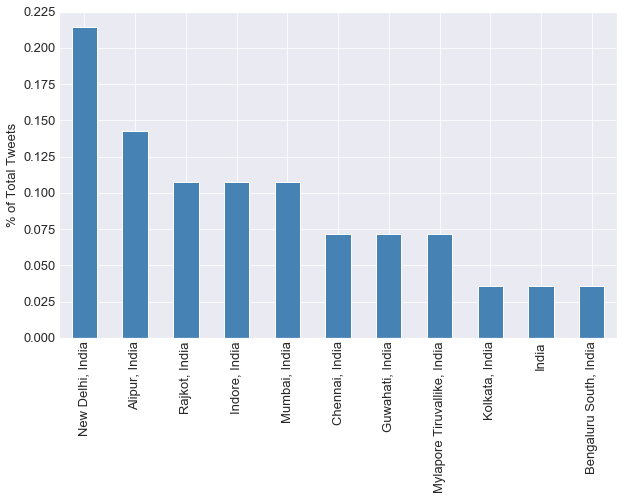

In [176]:
# plot histogram of tweets counts by country of origin
sns.set_style("darkgrid")
x = df.full_name.value_counts(1).head(20)
x.plot(kind='bar',figsize=(10,6),fontsize=13,color='steelblue')
plt.ylabel('% of Total Tweets', fontsize=13)

In [184]:
# get all the countries in dataset
df.user_loc.unique()

array(['Bhubaneshwar, India', 'Chennai', 'Mumbai', 'NEW DELHI, INDIA',
       'ÜT: 19.165487,72.853263', 'बिधान नगर, भारत', 'India',
       'Bengaluru, India', nan, 'Delhi', 'RAJKOT', 'कोलकाता, भारत',
       'Bhopal _ Delhi', 'New Delhi, India'], dtype=object)

In [187]:
# get top places in the dataset by percentage of tweets
df.user_loc.value_counts(1).head(20)

कोलकाता, भारत              0.173913
RAJKOT                     0.130435
NEW DELHI, INDIA           0.086957
Bengaluru, India           0.086957
New Delhi, India           0.086957
Chennai                    0.086957
Mumbai                     0.086957
बिधान नगर, भारत            0.043478
ÜT: 19.165487,72.853263    0.043478
Bhubaneshwar, India        0.043478
India                      0.043478
Bhopal _ Delhi             0.043478
Delhi                      0.043478
Name: user_loc, dtype: float64

Text(0, 0.5, '% of Total Tweets')

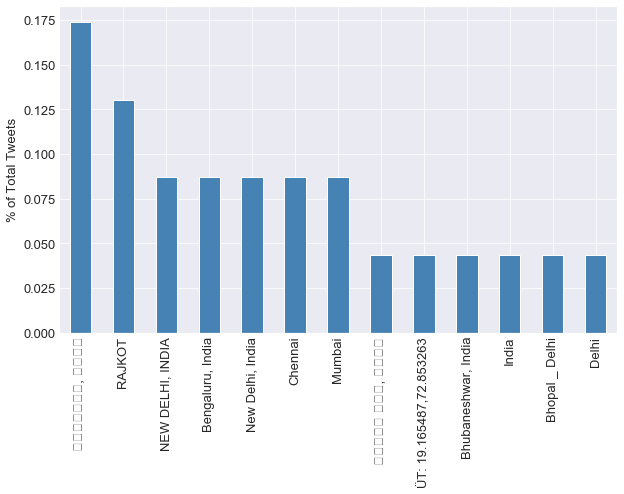

In [182]:
# plot histogram of tweets counts by country of origin
sns.set_style("darkgrid")
x = df.user_loc.value_counts(1).head(1000)
x.plot(kind='bar',figsize=(10,6),fontsize=13,color='steelblue')
plt.ylabel('% of Total Tweets', fontsize=13)

In [177]:
df.columns

Index(['date', 'user_loc', 'message', 'full_name', 'country', 'country_code',
       'geo_code', 'predictions'],
      dtype='object')

In [178]:
# get latitudes and longitudes

# some helper funtions to get longs and lats
def lats(x):
    return x[1]

def longs(x):
    return x[0]

# --------------------------------------------------------#
# append longs and lats to dframe
df['latitude'] = df['geo_code'].apply(lats)
df['longitude'] = df['geo_code'].apply(longs)
df.columns

Index(['date', 'user_loc', 'message', 'full_name', 'country', 'country_code',
       'geo_code', 'predictions', 'latitude', 'longitude'],
      dtype='object')

In [191]:


# for tweets extract place abreviations for a new origin column
# helper function to extract state origin of every tweet
def get_state(x):
    
    origin = x.split(',')[0].lstrip()    
    return origin

# ____________________________________________________________________________

# create origin column
df = df.copy()
df['origin'] = df['full_name'].apply(get_state)
list(df['origin'].head(100))

['Bengaluru South',
 'Chennai',
 'Mumbai',
 'New Delhi',
 'Mumbai',
 'Kolkata',
 'India',
 'New Delhi',
 'Mylapore Tiruvallike',
 'Guwahati',
 'Mylapore Tiruvallike',
 'Guwahati',
 'Chennai',
 'Mumbai',
 'New Delhi',
 'Rajkot',
 'Rajkot',
 'Rajkot',
 'Indore',
 'Alipur',
 'Alipur',
 'Indore',
 'Alipur',
 'New Delhi',
 'New Delhi',
 'Indore',
 'Alipur',
 'New Delhi']

In [192]:
# save updated dataframe
df.to_pickle('df_rafale_longs_lats.p')

In [193]:
# retrive updated dataframe
df = pd.read_pickle('df_rafale_longs_lats.p')

Text(0, 0.5, 'Origin of Tweets')

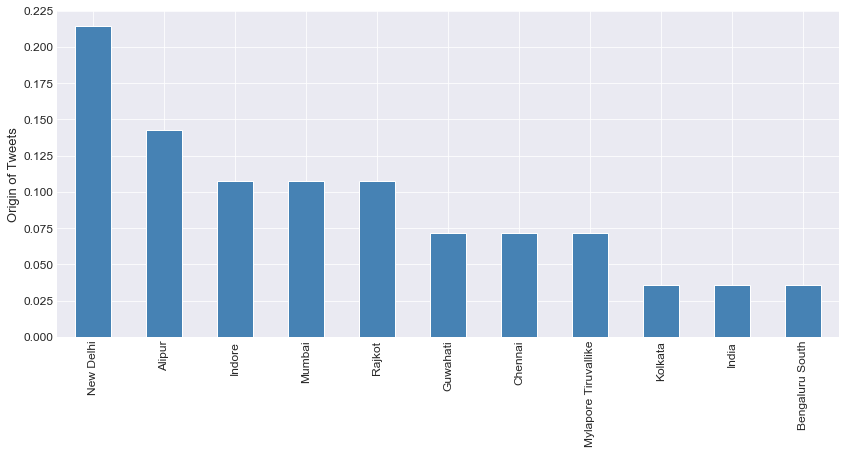

In [196]:
# plot tweets distribution by state

plt.style.use('seaborn-darkgrid')

x = df.origin.value_counts(1).head(20)
x.plot(kind='bar',figsize=(14,6),fontsize=12,color='steelblue')
plt.ylabel('Origin of Tweets', fontsize=13)

In [202]:
# extract total sentiment per origin
df_origin_sentiment = df.groupby(['origin'])['predictions'].value_counts().unstack().fillna(0.0).reset_index()
df_origin_sentiment['total_sentiment'] = -(df_origin_sentiment[0])+df_origin_sentiment[1] 
df_origin_sentiment

predictions,origin,0,1,total_sentiment
0,Alipur,4.0,0.0,-4.0
1,Bengaluru South,1.0,0.0,-1.0
2,Chennai,1.0,1.0,0.0
3,Guwahati,1.0,1.0,0.0
4,India,1.0,0.0,-1.0
5,Indore,3.0,0.0,-3.0
6,Kolkata,1.0,0.0,-1.0
7,Mumbai,3.0,0.0,-3.0
8,Mylapore Tiruvallike,2.0,0.0,-2.0
9,New Delhi,6.0,0.0,-6.0
